# 571 Group Project -- NYC Airbnb Price Prediction#

**Group Member: Yi Gao, Danning Su, Ting Ying, Xuewen Chen, Zhen Ren**

### Set Up

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from scipy import stats as sts

import sklearn as sk

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import re
import nltk
from nltk import FreqDist
from nltk import word_tokenize
import wordcloud
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer


from scipy import stats
from scipy.stats import norm, skew

%matplotlib inline 

## Data Resource and Project Purpose

Our data set is the New York City Airbnb Open Data, and the goal of this project is to find the relationship between the housing price and other features of the house by models we learned in ACCY 571. We hope we can build a useful model to help future Airbnb hosts and customers in judging whether the house price is reasonable.

Kaggle url: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

Full data source: http://insideairbnb.com/get-the-data.html

## Data Preprocessing

* Manually select the features which make sense in this model

In [4]:
%cd C:\Users\gao82\Desktop\571\group project
path = "NY AIRBNB 2019.csv"
df = pd.read_csv(path)
df_text = df[['amenities','name','summary','space','description']]
df1 = df[['id','neighbourhood_group_cleansed','latitude','longitude','price','property_type','room_type','accommodates',
         'cleaning_fee','minimum_nights','number_of_reviews','number_of_reviews_ltm','review_scores_rating','review_scores_accuracy',
        'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
        'cancellation_policy','reviews_per_month']]
df1.shape

C:\Users\gao82\Desktop\571\group project


(50599, 21)

***The dataset has 50599 rows and 21 columns.***

* Convert string price and cleaning fee to float

In [5]:
df1['price'] =  df1['price'].replace(to_replace = '\$', value = '', regex = True)
df1['price'] =  df1['price'].replace(to_replace = '\,', value = '', regex = True)
df1['price'] = df1['price'].astype('float')
df1['cleaning_fee'] = df1['cleaning_fee'].replace(to_replace = '\$', value = '', regex = True)
df1['cleaning_fee'] = df1['cleaning_fee'].replace(to_replace = '\,', value = '', regex = True)
df1['cleaning_fee'] = df1['cleaning_fee'].astype('float')

* Find out missing values and replace them with median value

In [6]:
#sum up null values for each feature
count = df1.isnull().sum()
percent = (df1.isnull().sum())/df1.isnull().count()
missing = pd.concat([count, percent], axis=1, keys=['count','percent']).sort_values('count', ascending=False)
missing.head(12)

,count,percent
review_scores_location,11218,0.221704
review_scores_value,11217,0.221684
review_scores_checkin,11214,0.221625
review_scores_accuracy,11198,0.221309
review_scores_communication,11195,0.221249
review_scores_cleanliness,11184,0.221032
review_scores_rating,11162,0.220597
cleaning_fee,10491,0.207336
reviews_per_month,10220,0.201980
number_of_reviews_ltm,0,0.000000


In [7]:
#get median
md_review_scores_location = df1['review_scores_location'].median()
md_review_scores_value = df1['review_scores_value'].median()
md_review_scores_checkin = df1['review_scores_checkin'].median()
md_review_scores_accuracy = df1['review_scores_accuracy'].median()
md_review_scores_communication = df1['review_scores_communication'].median()
md_review_scores_cleanliness = df1['review_scores_cleanliness'].median()
md_review_scores_rating = df1['review_scores_rating'].median()
md_cleaning_fee = df1['cleaning_fee'].median()
md_reviews_per_month = df1['reviews_per_month'].median()

# replace null with median
df1['review_scores_location'].fillna(md_review_scores_location,inplace=True)
df1['review_scores_value'].fillna(md_review_scores_value,inplace=True)
df1['review_scores_checkin'].fillna(md_review_scores_checkin,inplace=True)
df1['review_scores_accuracy'].fillna(md_review_scores_accuracy,inplace=True)
df1['review_scores_communication'].fillna(md_review_scores_communication,inplace=True)
df1['review_scores_cleanliness'].fillna(md_review_scores_cleanliness,inplace=True)
df1['review_scores_rating'].fillna(md_review_scores_rating,inplace=True)
df1['cleaning_fee'].fillna(md_cleaning_fee,inplace=True)
df1['reviews_per_month'].fillna(md_reviews_per_month,inplace=True)

#check if any missing values remain
count = df1.isnull().sum() #sum up null values for each feature
percent = (df1.isnull().sum())/df1.isnull().count()
missing = pd.concat([count, percent], axis=1, keys=['count','percent']).sort_values('count', ascending=False)
missing.head(12)

,count,percent
id,0,0.0
number_of_reviews_ltm,0,0.0
cancellation_policy,0,0.0
review_scores_value,0,0.0
review_scores_location,0,0.0
review_scores_communication,0,0.0
review_scores_checkin,0,0.0
review_scores_cleanliness,0,0.0
review_scores_accuracy,0,0.0
review_scores_rating,0,0.0


* exclude rows when price = 0 since it is not considered normal

In [8]:
df1[df1['price']<=0]

,id,neighbourhood_group_cleansed,latitude,longitude,price,property_type,room_type,accommodates,cleaning_fee,minimum_nights,...,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month
21519,18750597,Brooklyn,40.69023,-73.95428,0.0,Apartment,Private room,5,140.0,4,...,0,80.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,0.04
23802,20523843,Brooklyn,40.69467,-73.92433,0.0,Townhouse,Private room,2,20.0,2,...,5,94.0,10.0,8.0,10.0,10.0,10.0,9.0,flexible,0.58
23911,20608117,Brooklyn,40.72462,-73.94072,0.0,Apartment,Private room,2,30.0,2,...,0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,0.43
23936,20624541,Brooklyn,40.70838,-73.94645,0.0,Apartment,Entire home/apt,4,100.0,3,...,2,92.0,10.0,10.0,10.0,10.0,10.0,9.0,strict_14_with_grace_period,0.20
23953,20639628,Brooklyn,40.68173,-73.91342,0.0,Apartment,Private room,2,25.0,1,...,59,93.0,10.0,9.0,10.0,10.0,9.0,10.0,strict_14_with_grace_period,4.45
23954,20639792,Brooklyn,40.68279,-73.91170,0.0,Apartment,Private room,2,25.0,1,...,46,92.0,10.0,9.0,10.0,10.0,9.0,9.0,strict_14_with_grace_period,4.26
23955,20639914,Brooklyn,40.68258,-73.91284,0.0,Apartment,Private room,2,25.0,1,...,59,91.0,9.0,9.0,9.0,9.0,9.0,9.0,strict_14_with_grace_period,4.66
24371,20933849,Manhattan,40.75091,-73.97597,0.0,Apartment,Entire home/apt,1,50.0,3,...,0,96.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,0.74
24908,21291569,Brooklyn,40.69211,-73.90670,0.0,Apartment,Shared room,3,40.0,30,...,1,70.0,6.0,6.0,10.0,7.0,8.0,8.0,strict_14_with_grace_period,0.09
24932,21304320,Brooklyn,40.69166,-73.90928,0.0,Townhouse,Shared room,3,40.0,30,...,3,96.0,10.0,9.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,0.25


In [9]:
# delete the rows with price=0.
df1 = df1[df1['price'] !=0]

In [10]:
df1.head()

,id,neighbourhood_group_cleansed,latitude,longitude,price,property_type,room_type,accommodates,cleaning_fee,minimum_nights,...,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month
0,2595,Manhattan,40.75362,-73.98377,225.0,Apartment,Entire home/apt,1,95.0,10,...,7,94.0,9.0,9.0,10.0,10.0,10.0,9.0,strict_14_with_grace_period,0.39
1,3831,Brooklyn,40.68514,-73.95976,89.0,Guest suite,Entire home/apt,3,50.0,1,...,75,90.0,9.0,9.0,10.0,9.0,10.0,9.0,moderate,4.67
2,5099,Manhattan,40.74767,-73.97500,200.0,Apartment,Entire home/apt,2,125.0,3,...,8,90.0,10.0,9.0,10.0,10.0,10.0,9.0,moderate,0.60
3,5121,Brooklyn,40.68688,-73.95596,60.0,Apartment,Private room,2,0.0,29,...,0,90.0,8.0,8.0,10.0,10.0,9.0,9.0,strict_14_with_grace_period,0.38
4,5178,Manhattan,40.76489,-73.98493,79.0,Apartment,Private room,2,15.0,2,...,47,84.0,9.0,7.0,9.0,9.0,10.0,8.0,strict_14_with_grace_period,3.52


## Insights to the data

* Two plots showing the distribution of housing price

Text(0, 0.5, 'frequency')

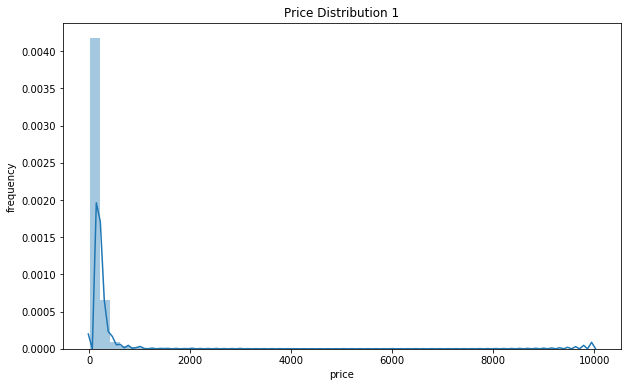

In [11]:
fig,ax = plt.subplots(figsize=(10,6))
sns.distplot(df1['price'])
plt.title('Price Distribution 1')
plt.ylabel('frequency')

Text(0.5, 0, 'price')

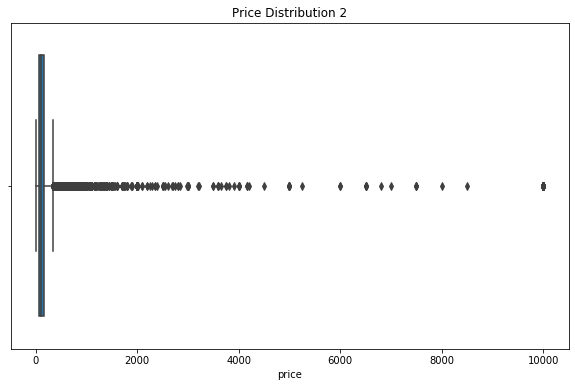

In [12]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(x=df1['price'])
plt.title('Price Distribution 2')
plt.xlabel('price')

In [13]:
print(df1['price'].describe())

count    50583.000000
mean       158.221814
std        348.133242
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


In [14]:
print(df1['price'].skew())
print(df1['price'].kurt())

21.268621150832395
556.1243859828036


We can know from above that Airbnb price distrubtion is rather skewed to the right instead of normal. It has a positive long thin tail whereas the majority of the distribution is concentraded on the left of the distribution figure. In addition, the range is large as Airbnb prices in NYC vary a lot from departments to departments.

* Show the influence from neighbourhood group on price

Text(0, 0.5, 'Price')

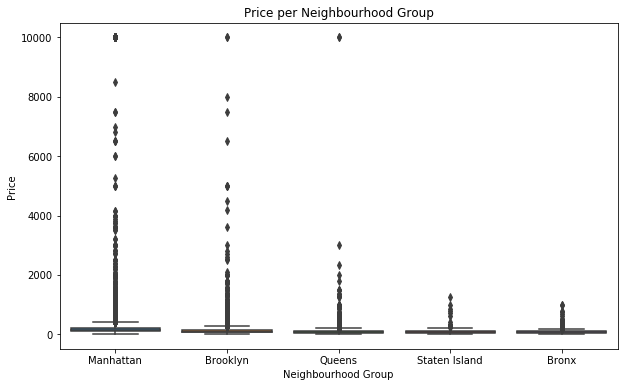

In [15]:
#price per neighborhood group 
x='neighbourhood_group_cleansed'
y='price'
title='Price per Neighbourhood Group'
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(x=x, y=y, data=df1)
plt.title(title)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Price')

* Show the price distribution in each nerghbourhood

Text(0, 0.5, 'price')

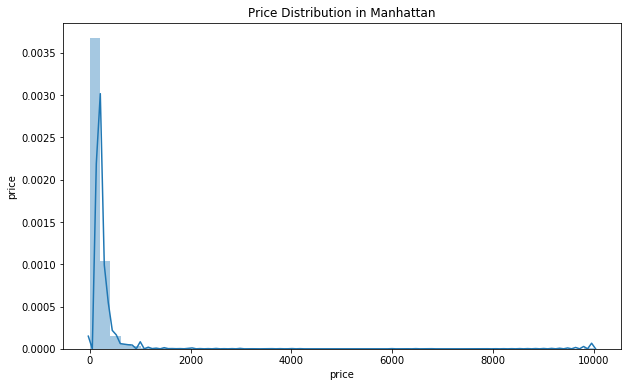

In [16]:
fig,ax = plt.subplots(figsize=(10,6))
sns.distplot(df1[df1['neighbourhood_group_cleansed']=='Manhattan']['price'])
plt.title('Price Distribution in Manhattan')
plt.ylabel('price')

Text(0, 0.5, 'price')

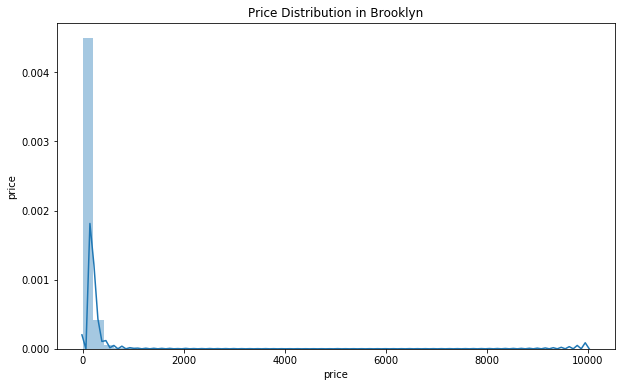

In [17]:
fig,ax = plt.subplots(figsize=(10,6))
sns.distplot(df1[df1['neighbourhood_group_cleansed']=='Brooklyn']['price'])
plt.title('Price Distribution in Brooklyn')
plt.ylabel('price')

Text(0, 0.5, 'price')

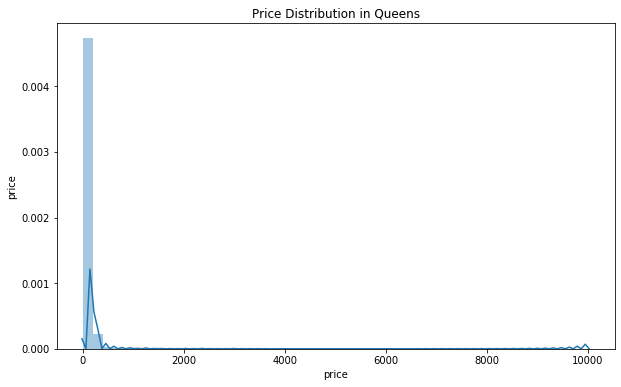

In [18]:
fig,ax = plt.subplots(figsize=(10,6))
sns.distplot(df1[df1['neighbourhood_group_cleansed']=='Queens']['price'])
plt.title('Price Distribution in Queens')
plt.ylabel('price')

Text(0, 0.5, 'price')

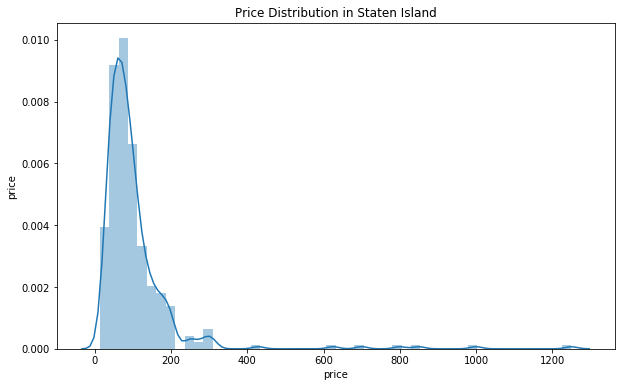

In [19]:
fig,ax = plt.subplots(figsize=(10,6))
sns.distplot(df1[df1['neighbourhood_group_cleansed']=='Staten Island']['price'])
plt.title('Price Distribution in Staten Island')
plt.ylabel('price')

Text(0, 0.5, 'price')

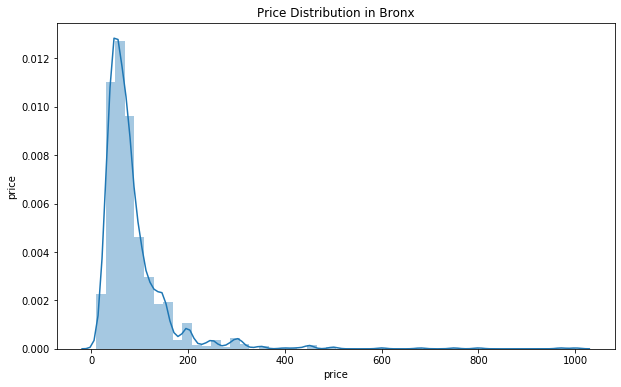

In [20]:
fig,ax = plt.subplots(figsize=(10,6))
sns.distplot(df1[df1['neighbourhood_group_cleansed']=='Bronx']['price'])
plt.title('Price Distribution in Bronx')
plt.ylabel('price')

* Show the distribution of houses in different neighbourhoods of NYC

Text(0.5, 1.0, 'Distribution of House in New York City')

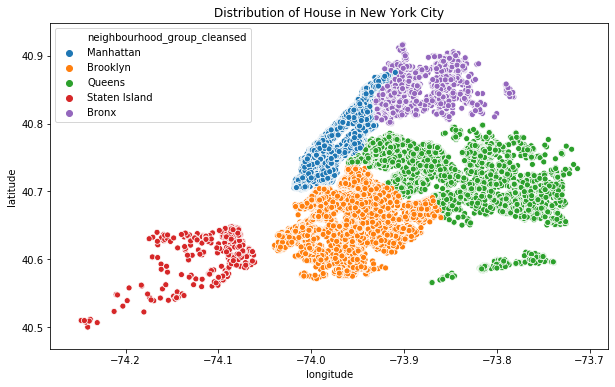

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(df1.longitude,df1.latitude,hue=df1.neighbourhood_group_cleansed)
plt.title('Distribution of House in New York City')

From these two plots, we can find the distribution of Airbnbs, and how location influences the price of Airbnbs in New York City.

* Show percentage of different house types

<function matplotlib.pyplot.show(*args, **kw)>

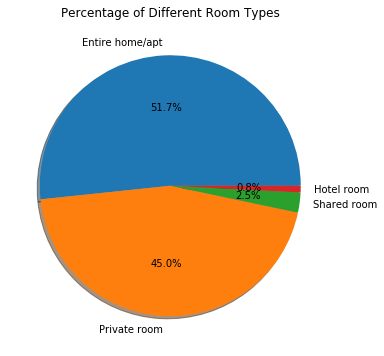

In [22]:
fig1, ax1 = plt.subplots(figsize=(10,6))
counts_rt = df1['room_type'].value_counts()
ax1.pie(counts_rt,labels=counts_rt.index, autopct='%1.1f%%',shadow=True)
plt.title('Percentage of Different Room Types')
plt.show

## Feature Selection and Feature Engineering

Next step we transform categorical columns into dummy variables(one-hot encoding) and add these new columns to original dataframe to convert neighbourhood groups into numerical features

In [23]:
df_neighbour = pd.get_dummies(df1['neighbourhood_group_cleansed'])
df_room = pd.get_dummies(df1['room_type'])
df_cancell = pd.get_dummies(df1['cancellation_policy'])
df_combined = pd.concat([df1,df_neighbour,df_room,df_cancell],axis = 1)

# select the data with numeric values
df_combined = df_combined[['price','latitude','longitude','accommodates',
                           'cleaning_fee','minimum_nights','number_of_reviews',
                           'number_of_reviews_ltm','review_scores_rating',
                           'review_scores_accuracy','review_scores_cleanliness',
                           'review_scores_checkin','review_scores_communication'
                           ,'review_scores_location','review_scores_value',
                           'reviews_per_month','Bronx','Brooklyn',
                           'Manhattan','Queens','Staten Island',
                           'Entire home/apt','Hotel room','Private room',
                           'Shared room','flexible','moderate','strict',
                           'strict_14_with_grace_period','super_strict_30',
                           'super_strict_60']]

In [24]:
print(df_combined['price'].describe())

count    50583.000000
mean       158.221814
std        348.133242
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


From the previous section, we know that price vary a lot. For the sake of predicting the majority of Airbnb in NYC, we decide to drop rows with price > 500 as it only represent a tiny portion of the houses in NYC. 

In [25]:
drop_num = df_combined[df_combined['price']> 500].shape[0]
drop_percent = drop_num/df_combined['price'].shape[0]
print(f'the number of rows that will be dropped is {drop_num} and it is {drop_percent*100} percents of the total')
df_combined = df_combined[df_combined['price']<= 550]

the number of rows that will be dropped is 1070 and it is 2.1153351916651837 percents of the total


From the previous section, we know that the target variable, price, is pretty skewed to the right. We decide to apply log transformation to it.

Text(0.5, 1.0, 'Price Distribution(After logarithm)')

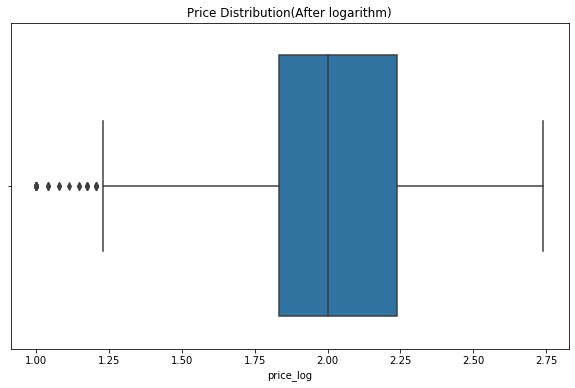

In [26]:
fig,ax = plt.subplots(figsize=(10,6))
df_combined['price_log'] = np.log10(df_combined['price'])
sns.boxplot(x=df_combined['price_log'])
plt.title('Price Distribution(After logarithm)')
# to reverse the change
# df_combined['price'] = (10**df_combined['price']) 

mu is 131.97064098172365 and sigma is 89.63771970325021


Text(0, 0.5, 'frequency')

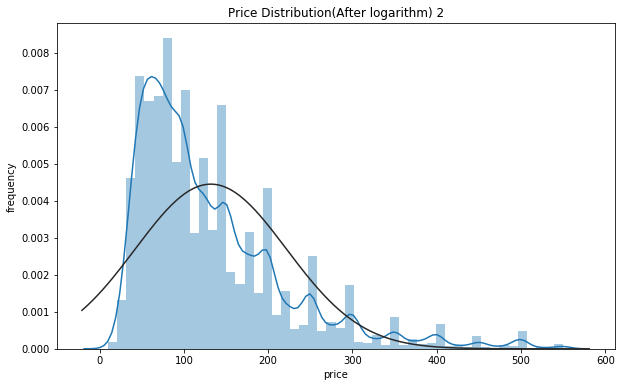

In [27]:
fig,ax = plt.subplots(figsize=(10,6))
sns.distplot(df_combined['price'],fit=norm)
mu,sigma = norm.fit(df_combined['price'])
print(f'mu is {mu} and sigma is {sigma}')
plt.title('Price Distribution(After logarithm) 2')
plt.ylabel('frequency')

After the log transformation, we can see that boxplot improves and but still shows a slight skewness to the right.

We use correlation matrix to try to find the realtionships among different features.

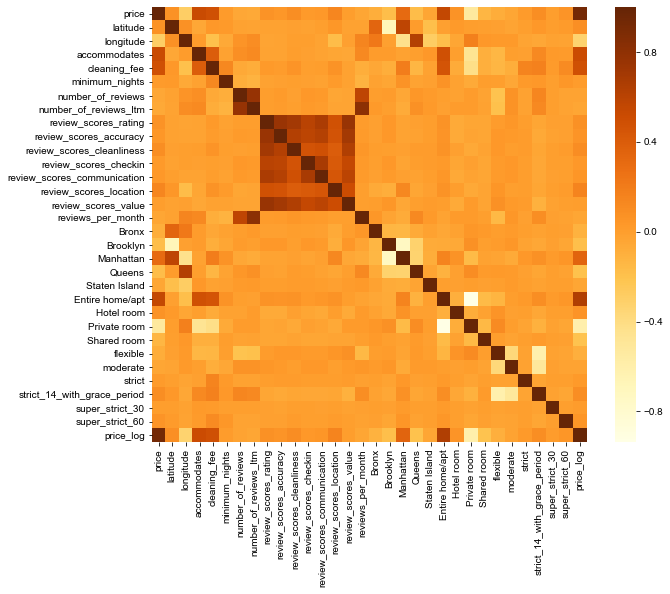

In [28]:
cor = df_combined.corr()
fig2,ax2 = plt.subplots(figsize=(10,8))
sns.heatmap(cor,vmax=1,square=True, cmap='YlOrBr')
sns.set(font_scale=1.0)

We can see from above graph that currently there are no strong features that are correlated to price. We can also see that there are strong correlations among different review scores, some of which we need to eliminate. 

To avoid multicollinearity problem among different review scores, we use selectKBest to determine the best review score and drop the rest scores.  

In [29]:
#SelectKBest
from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
skb = SelectKBest(k='all')
fs_x = df_combined[['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness',
                    'review_scores_checkin','review_scores_communication',
                    'review_scores_location','review_scores_value']]
fs_y = df_combined['price_log']
fs = skb.fit(fs_x, fs_y)
#result dataframe
data = zip(fs_x.columns,fs.scores_)
skb_result = pd.DataFrame(data,columns = ['features','scores'])
skb_result.sort_values(['scores'], ascending = False, inplace=True)
skb_result.reset_index(inplace = True,drop = True)
skb_result

,features,scores
0,review_scores_location,3.920937
1,review_scores_cleanliness,2.193104
2,review_scores_rating,1.819956
3,review_scores_communication,1.625238
4,review_scores_accuracy,1.521796
5,review_scores_value,1.390330
6,review_scores_checkin,1.309331


In [30]:
df_combined = df_combined.drop(columns=['review_scores_cleanliness','review_scores_rating',
                                        'review_scores_accuracy','review_scores_communication',
                                        'review_scores_value','review_scores_checkin'])

In [31]:
df_combined.head()

,price,latitude,longitude,accommodates,cleaning_fee,minimum_nights,number_of_reviews,number_of_reviews_ltm,review_scores_location,reviews_per_month,...,Hotel room,Private room,Shared room,flexible,moderate,strict,strict_14_with_grace_period,super_strict_30,super_strict_60,price_log
0,225.0,40.75362,-73.98377,1,95.0,10,48,7,10.0,0.39,...,0,0,0,0,0,0,1,0,0,2.352183
1,89.0,40.68514,-73.95976,3,50.0,1,295,75,10.0,4.67,...,0,0,0,0,1,0,0,0,0,1.949390
2,200.0,40.74767,-73.97500,2,125.0,3,78,8,10.0,0.60,...,0,0,0,0,1,0,0,0,0,2.301030
3,60.0,40.68688,-73.95596,2,0.0,29,49,0,9.0,0.38,...,0,1,0,0,0,0,1,0,0,1.778151
4,79.0,40.76489,-73.98493,2,15.0,2,454,47,10.0,3.52,...,0,1,0,0,0,0,1,0,0,1.897627


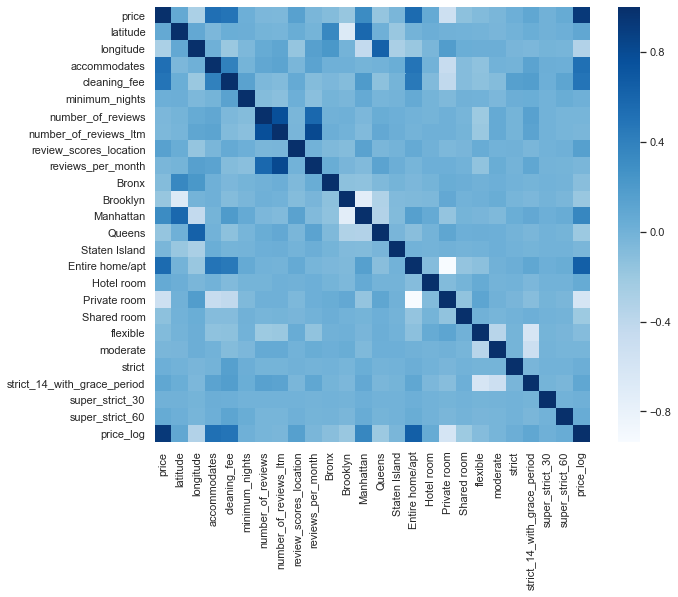

In [32]:
cor2 = df_combined.corr()
fig2,ax2 = plt.subplots(figsize=(10,8))
sns.heatmap(cor2,vmax=1,square=True,cmap="Blues")
sns.set(font_scale=1.0)

From the above headmap, the correlations between price and features are significantly improved. We can find:

Strong positive relationships between price_log and:

*   Accommodates
*   Cleaning_fee
*   Manhattan
*   Entire home/apt

Strong negative relationships between price and:
*   Private room
*   longitude

In [44]:
features = df_combined[['latitude','longitude','accommodates',
                           'cleaning_fee','minimum_nights','number_of_reviews',
                           'number_of_reviews_ltm','review_scores_location',
                           'reviews_per_month','Bronx','Brooklyn',
                           'Manhattan','Queens','Staten Island',
                           'Entire home/apt','Hotel room','Private room',
                           'Shared room','flexible','moderate','strict',
                           'strict_14_with_grace_period','super_strict_30',
                           'super_strict_60']]
label = df_combined['price_log']

In [45]:
features = features.astype('float')
label = label.astype('float')

## Model - Regression Analyzes

We apply regression models to explore how the selected features influence the price of Airbnb in New York. Since we have more than 100k entries, we didn't use SGD Regressor here.

### Preparation before machine learning models

* Split the data into train and test sets

In [46]:
frac = 0.25
x_train,x_test,y_train,y_test \
  = train_test_split(features,label,
                     test_size=frac ,random_state = 23)

* Standarize the features to normal distribution

In [47]:
sc = StandardScaler()
# fit scaler and transform train and test feature
x_train1 = sc.fit_transform(x_train)
x_test1 = sc.transform(x_test)

### Model 1: Linear Regression

In [38]:
# linear regression
linear_model=LinearRegression(fit_intercept=True)
linear_model.fit(x_train1,y_train)
y_pred=linear_model.predict(x_test1)
score=100.0 * linear_model.score(x_test1,y_test)
print(f'Multivariate LR Model score = {score:5.2f}%')

Multivariate LR Model score = 62.24%


Text(0.5, 1.0, 'Linear Regression Prediction')

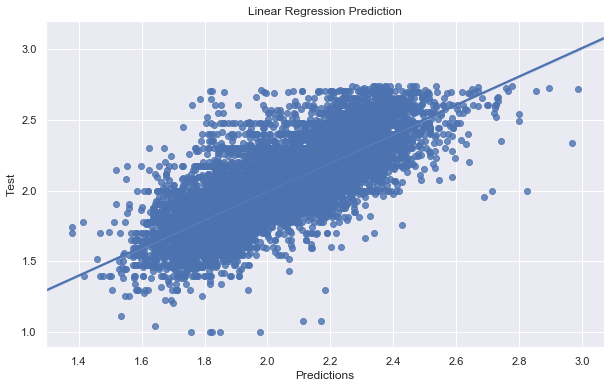

In [39]:
plt.figure(figsize=(10,6))
sns.regplot(y_pred,y_test)
plt.xlabel('Predictions')
plt.ylabel('Test')
plt.title('Linear Regression Prediction')

In [40]:
lm_y_pred1=linear_model.predict(x_train1)
lm_y_pred2=linear_model.predict(x_test1)
linear_best_results = pd.DataFrame({'algorithm':['Linear Regression'],
            'training_error': [mean_squared_error(y_train, lm_y_pred1)],
            'test_error': [mean_squared_error(y_test, lm_y_pred2)],
            'training_r2_score': [r2_score(y_train, lm_y_pred1)],
            'test_r2_score': [r2_score(y_test, lm_y_pred2)]})
pd.options.display.float_format = '{:.2%}'.format
linear_best_results

,algorithm,training_error,test_error,training_r2_score,test_r2_score
0,Linear Regression,2.87%,2.87%,62.09%,62.24%


### Model 2: Ridge Regression

Ridge regression adds in penalty term lambda to avoid overfitting; good when there is not enough sample data  

In [48]:
# Run the model before tuning the hyperparameter
ridge_model = Ridge()
ridge_model.fit(x_train1, y_train)
ridge_pred = ridge_model.predict(x_test1)
print('Score = {:.2%}'.format(ridge_model.score(x_test1,y_test)))

Score = 62.24%


* Discussion about hyperparameter of Ridge

In [49]:
parameter_space = {
    "alpha": [0.001,0.1,1,10,20,30,40,45,50,100],
    "fit_intercept": [True, False],
    "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
}

clf = GridSearchCV(Ridge(random_state=3), parameter_space, n_jobs=-1,
                   cv=3)

clf.fit(x_train1, y_train)
print("Best parameters:")
print(clf.best_params_)

Best parameters:
{'alpha': 100, 'fit_intercept': True, 'solver': 'lsqr'}


From this analysis we can see, a medium alpha value is best, indicating that a considerable penalty term should be included to reduce the over-fitting issue of the model.

* Ridge Regreesion using the hyperparameter above

In [50]:
ridge_model_best = Ridge(random_state=23, **clf.best_params_)
ridge_model_best.fit(x_train1, y_train)
ridge_pred = ridge_model_best.predict(x_test1)
ridge_mae = mean_absolute_error(y_test, ridge_pred)
print('Score = {:.2%}'.format(ridge_model_best.score(x_test1,y_test)))

Score = 62.24%


In [51]:
y_pred_ridge1=ridge_model_best.predict(x_train1)
y_pred_ridge2= ridge_model_best.predict(x_test1)
ridge_best_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'training_error': [mean_squared_error(y_train, y_pred_ridge1)],
            'test_error': [mean_squared_error(y_test, y_pred_ridge2)],
            'training_r2_score': [r2_score(y_train, y_pred_ridge1)],
            'test_r2_score': [r2_score(y_test, y_pred_ridge2)]})
pd.options.display.float_format = '{:.2%}'.format
ridge_best_results

,algorithm,training_error,test_error,training_r2_score,test_r2_score
0,Ridge Regression,2.87%,2.86%,62.09%,62.24%


However, from the result showed above, there are very small difference between the scores of the linear model. Therefore, we decide to make no change to the model.

### Model 3: Lasso Regression

* Discussion about hyperparameter of Lasso

In [52]:
# try to figure out the best alpha value of lasso
lassocv=LassoCV(eps=0.00001, n_alphas=100, alphas=None)
lassocv.fit(x_train1,y_train)
# the penalty term chosen by the CV
lassocv.alpha_

5.865591748943223e-05

* Lasso Regression using the hyperparameter above, which is small, indicating no need for adding the penalty term

In [53]:
# lasso regression [regularization2]
# lasso regression can exclude useless variable from models; good when there are lots of bad variables  
lasso_model_best=Lasso(alpha=lassocv.alpha_)
lasso_model_best.fit(x_train1,y_train)
lasso_score=lasso_model_best.score(x_test1,y_test)
lasso_coef=lasso_model_best.coef_
print(lasso_score)
print(lasso_coef)

0.6224252623059021
[-0.01223504 -0.04920065  0.07765512  0.03725249 -0.01377464  0.0010082
 -0.01108399  0.02168317  0.00213333 -0.0051568  -0.02208516  0.03819677
  0.         -0.02820216  0.10515127  0.02192947 -0.         -0.02422392
  0.00201067  0.         -0.00384258 -0.00086244 -0.00393578  0.00053736]


In [56]:
y_pred_lasso1= lasso_model_best.predict(x_train1)
y_pred_lasso2= lasso_model_best.predict(x_test1)
Lasso_best_results = pd.DataFrame({'algorithm':['Lasso Regression'],
            'training_error': [mean_squared_error(y_train, y_pred_lasso1)],
            'test_error': [mean_squared_error(y_test, y_pred_lasso2)],
            'training_r2_score': [r2_score(y_train, y_pred_lasso1)],
            'test_r2_score': [r2_score(y_test, y_pred_lasso2)]})
pd.options.display.float_format = '{:.2%}'.format
Lasso_best_results

,algorithm,training_error,test_error,training_r2_score,test_r2_score
0,Lasso Regression,2.87%,2.86%,62.09%,62.24%


The results from the Lasso regression model are similar to the ones from linear regression and ridge regression.

## Comparison of Linear Models

In [57]:
#combined scores of above model's best results
df_comparison = pd.concat([linear_best_results,ridge_best_results,Lasso_best_results], axis=0, ignore_index=True)
df_comparison

,algorithm,training_error,test_error,training_r2_score,test_r2_score
0,Linear Regression,2.87%,2.87%,62.09%,62.24%
1,Ridge Regression,2.87%,2.86%,62.09%,62.24%
2,Lasso Regression,2.87%,2.86%,62.09%,62.24%


Frome the result table, we can see the linear model based on selected features could explain 62.24% of the variation of price. The difference between linear models are barely visible. Next, we consider building ensemble models.

### Model 4: Random Forest Regression

In [58]:
# Random Forest Regression (Defalut Parameters)
randomforest_model=RandomForestRegressor(random_state=23)
randomforest_model=randomforest_model.fit(x_train1,y_train)
print('Score = {:.2%}'.format(randomforest_model.score(x_test1,y_test)))

Score = 67.52%


In [59]:
y_train_pred = randomforest_model.predict(x_train1)
pred_tree=randomforest_model.predict(x_test1)
training_error = mean_squared_error(y_train_pred, y_train)
mse = mean_squared_error(y_test, pred_tree)
print(f'Training MSE   = {training_error:4.2%}')
print(f'Testing MSE    = {mse:4.2%}')

Training MSE   = 0.43%
Testing MSE    = 2.46%


The default Random Forest Regression Model gives a score of 67.52%. But notice Training MSE is significantly smaller than Testing MSE, which indicates that there is a over-fitting problem. To solve the over-fitting problem, We need to cut down features of less importance and apply cross-validation.

In [60]:
# Feature importance
df_fi = pd.DataFrame(zip(features, randomforest_model.feature_importances_),columns = ['Feature','Feature Importance'])
df_fi.sort_values(['Feature Importance'], ascending = False, inplace=True)
df_fi.reset_index(inplace = True,drop = True)
df_fi

,Feature,Feature Importance
0,Entire home/apt,42.18%
1,longitude,12.38%
2,latitude,11.50%
3,cleaning_fee,7.41%
4,accommodates,6.71%
5,reviews_per_month,3.93%
6,Manhattan,3.87%
7,minimum_nights,3.38%
8,number_of_reviews,2.91%
9,number_of_reviews_ltm,1.91%


In [61]:
# Drop features that have importance less than 0.005
drop_features = []
for i in df_fi['Feature Importance']:
    if i < 0.005:
        drop_features.append(i)
        
features = features.drop(columns=['moderate','Private room','Shared room',
                                  'Hotel room','Brooklyn',
                                  'Queens','Bronx','super_strict_30','super_strict_60',
                                  'strict','Staten Island'])
features.head()

,latitude,longitude,accommodates,cleaning_fee,minimum_nights,number_of_reviews,number_of_reviews_ltm,review_scores_location,reviews_per_month,Manhattan,Entire home/apt,flexible,strict_14_with_grace_period
0,4075.36%,-7398.38%,100.00%,9500.00%,1000.00%,4800.00%,700.00%,1000.00%,39.00%,100.00%,100.00%,0.00%,100.00%
1,4068.51%,-7395.98%,300.00%,5000.00%,100.00%,29500.00%,7500.00%,1000.00%,467.00%,0.00%,100.00%,0.00%,0.00%
2,4074.77%,-7397.50%,200.00%,12500.00%,300.00%,7800.00%,800.00%,1000.00%,60.00%,100.00%,100.00%,0.00%,0.00%
3,4068.69%,-7395.60%,200.00%,0.00%,2900.00%,4900.00%,0.00%,900.00%,38.00%,0.00%,0.00%,0.00%,100.00%
4,4076.49%,-7398.49%,200.00%,1500.00%,200.00%,45400.00%,4700.00%,1000.00%,352.00%,100.00%,0.00%,0.00%,100.00%


In [62]:
# Split and scale the new dataframe
frac = 0.25
x_train2,x_test2,y_train2,y_test2 \
  = train_test_split(features,label,
                     test_size=frac ,random_state = 23)

In [63]:
sc = StandardScaler()
# fit scaler and transform train and test feature
x_train2 = sc.fit_transform(x_train2)
x_test2 = sc.transform(x_test2)

**Model2 - Random Forest Regression with Cross-Validation**

In [64]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop=400,num=10)]
# Maximum number of depth levels in tree
max_depth = [int(x) for x in np.linspace(start = 200, stop=400,num=20)]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5,6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 10, stop=20,num=10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [300, 311, 322, 333, 344, 355, 366, 377, 388, 400], 'max_depth': [200, 210, 221, 231, 242, 252, 263, 273, 284, 294, 305, 315, 326, 336, 347, 357, 368, 378, 389, 400], 'min_samples_split': [2, 3, 4, 5, 6], 'min_samples_leaf': [10, 11, 12, 13, 14, 15, 16, 17, 18, 20], 'bootstrap': [True, False]}


In [65]:
# Apply RandomizedSearchCV to search for the best parameters
randomforest_model_cv=RandomizedSearchCV(RandomForestRegressor(random_state=23), 
                         random_grid, cv=3, n_jobs=-1,
                         scoring="r2", 
                         n_iter=10, random_state=23)
randomforest_model_cv.fit(x_train2,y_train2)
randomforest_model_cv.best_params_,randomforest_model_cv.best_score_

({'n_estimators': 355,
  'min_samples_split': 4,
  'min_samples_leaf': 13,
  'max_depth': 326,
  'bootstrap': True},
 0.6928839947570725)

In [66]:
# Best Random Forest model
randomforest_model_best=RandomForestRegressor(random_state=23,n_estimators = 355, min_samples_split = 4,
                                  min_samples_leaf = 13, max_depth = 326, bootstrap = True)
randomforest_model_best=randomforest_model_best.fit(x_train2,y_train2)
print('Score = {:.2%}'.format(randomforest_model_best.score(x_test2,y_test2)))

Score = 69.96%


In [67]:
y_pred_forest1=randomforest_model_best.predict(x_train2)
y_pred_forest2= randomforest_model_best.predict(x_test2)
randomforest_best_results = pd.DataFrame({'algorithm':['Random Forest Regression'],
            'training_error': [mean_squared_error(y_train2, y_pred_forest1)],
            'test_error': [mean_squared_error(y_test2, y_pred_forest2)],
            'training_r2_score': [r2_score(y_train2, y_pred_forest1)],
            'test_r2_score': [r2_score(y_test2, y_pred_forest2)]})
pd.options.display.float_format = '{:.2%}'.format
randomforest_best_results

,algorithm,training_error,test_error,training_r2_score,test_r2_score
0,Random Forest Regression,1.68%,2.28%,77.81%,69.96%


After tuning the hyperparameters, the over-fitting problem is not as significant as before. The final score is 69.96%, which is not satisfactory.

### Model 5: Gradient Boosting Regression

In [58]:
# Default parameters
gb=GradientBoostingRegressor(random_state=23)
gb.fit(x_train1, y_train)
print('Score = {:.2%}'.format(gb.score(x_test1,y_test)))

Score = 69.16%


In [59]:
# Default parameters
gb=GradientBoostingRegressor(random_state=23)
gb.fit(x_train2, y_train2)
print('Score = {:.2%}'.format(gb.score(x_test2,y_test2)))

Score = 68.18%


In [63]:
y_train_pred = gb.predict(x_train2)
pred_tree=gb.predict(x_test2)
training_error = mean_squared_error(y_train_pred, y_train2)
mse = mean_squared_error(y_test2, pred_tree)
print(f'Training MSE   = {training_error:4.2%}')
print(f'Testing MSE    = {mse:4.2%}')

Training MSE   = 2.35%
Testing MSE    = 2.41%


**Model5 - Hyperparameters Tuning**

In [64]:
# n_estimators
para_test1={'n_estimators':range(350,391,10)}
gb1=GridSearchCV(GradientBoostingRegressor(random_state=23),param_grid=para_test1, cv=3,n_jobs=-1)
gb1.fit(x_train2, y_train2)
gb1.best_params_, gb1.best_score_

({'n_estimators': 390}, 0.6905216478532044)

In [65]:
# max_depth and min_samples_split
para_test2={'max_depth':range(3,14,2), 'min_samples_split':range(100,161,10)}
gb2=GridSearchCV(GradientBoostingRegressor(random_state=23,n_estimators=390),param_grid=para_test2, cv=3,n_jobs=-1)
gb2.fit(x_train2, y_train2)
gb2.best_params_, gb2.best_score_

({'max_depth': 7, 'min_samples_split': 110}, 0.6984630430252174)

In [66]:
# min_samples_leaf
para_test3={'min_samples_leaf':range(10,71,10)}
gb3=GridSearchCV(GradientBoostingRegressor(random_state=23,n_estimators=390,
                                            max_depth=7,min_samples_split = 110),
                  param_grid=para_test3, cv=3,n_jobs=-1)
gb3.fit(x_train2, y_train2)
gb3.best_params_, gb3.best_score_

({'min_samples_leaf': 50}, 0.6999401780359996)

In [70]:
para_test4={'learning_rate':[0.01,0.03,0.05,0.07,0.09]}
gb4=GridSearchCV(GradientBoostingRegressor(random_state=23,n_estimators=390,
                                            max_depth=7,min_samples_split = 110,min_samples_leaf = 50),
                  param_grid=para_test4, cv=3,n_jobs=-1)
gb4.fit(x_train2, y_train2)
gb4.best_params_, gb4.best_score_

({'learning_rate': 0.05}, 0.7004836121557843)

In [68]:
# Best GradientBoostingRegressor
best_gb=GradientBoostingRegressor(random_state=23,n_estimators=390,
                                 max_depth=7,min_samples_split = 110,min_samples_leaf = 50,learning_rate=0.05)
best_gb.fit(x_train2,y_train2)
y_pred = best_gb.predict(x_test2)
print('Score = {:.2%}'.format(best_gb.score(x_test2,y_test2)))

Score = 70.48%


Text(0.5, 1.0, 'GradientBoostingRegressor Prediction')

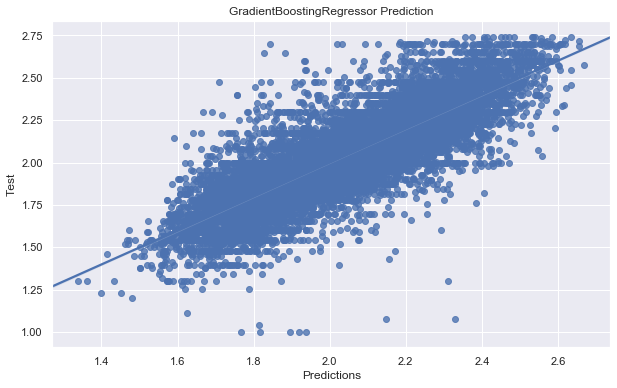

In [72]:
plt.figure(figsize=(10,6))
sns.regplot(y_pred,y_test2)
plt.xlabel('Predictions')
plt.ylabel('Test')
plt.title('GradientBoostingRegressor Prediction')

In [69]:
gb_train_pred=best_gb.predict(x_train2)
gb_pred= best_gb.predict(x_test2)
gb_best_results = pd.DataFrame({'algorithm':['Gradient Boosting Regression'],
            'training_error': [mean_squared_error(y_train2, gb_train_pred)],
            'test_error': [mean_squared_error(y_test2, gb_pred)],
            'training_r2_score': [r2_score(y_train2, gb_train_pred)],
            'test_r2_score': [r2_score(y_test2, gb_pred)]})
pd.options.display.float_format = '{:.2%}'.format
gb_best_results

,algorithm,training_error,test_error,training_r2_score,test_r2_score
0,Gradient Boosting Regression,1.82%,2.24%,76.05%,70.48%


After tuning the hyperparameters, the prediction score has improved to 70.48%, the best score so far. It seems boosting method has better performance in predicting complex non-linear relationships. But notice the difference between testing error and training error has increased, the model could have an underlying over-fitting problem.

### Model 6: XGBoost Analysis

In [39]:
my_model = XGBRegressor()
my_model.fit(x_train2, y_train2)
y_pred = my_model.predict(x_test2)
print('Score = {:.2%}'.format(my_model.score(x_test2,y_test2)))

Score = 69.98%


In [41]:
y_train_pred= my_model.predict(x_train2)
pred_xgb=my_model.predict(x_test2)
training_error = mean_squared_error(y_train_pred, y_train2)
mse = mean_squared_error(y_test2, pred_xgb)
print(f'Training MSE   = {training_error:4.2%}')
print(f'Testing MSE    = {mse:4.2%}')

Training MSE   = 1.66%
Testing MSE    = 2.28%


**Model6 - Hyperparameters Tuning**

In [43]:
cv_params = {'n_estimators': [500,530,550,580]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(x_train2, y_train2)
print('best param：{0}'.format(optimized_GBM.best_params_))
print('best score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.6min finished


best param：{'n_estimators': 550}
best score:0.701480445705


In [44]:
cv_params1 = {'max_depth': [3, 4, 5, 6, 7], 'min_child_weight': [2, 3, 4, 5, 6]}
other_params1 = {'learning_rate': 0.1, 'n_estimators': 550, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model1 = XGBRegressor(**other_params1)
optimized_GBM1 = GridSearchCV(estimator=model1, param_grid=cv_params1, scoring='r2', cv=5, verbose=1, n_jobs=-1)
optimized_GBM1.fit(x_train2, y_train2)
print('best param：{0}'.format(optimized_GBM1.best_params_))
print('best score:{0}'.format(optimized_GBM1.best_score_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 10.7min finished


best param：{'max_depth': 6, 'min_child_weight': 5}
best score:0.7021759131337794


In [48]:
cv_params2 = {'gamma': [0.07,0.08,0.09, 0.1, 0.2]}
other_params2 = {'learning_rate': 0.1, 'n_estimators': 550, 'max_depth': 6, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model2 = XGBRegressor(**other_params2)
optimized_GBM2 = GridSearchCV(estimator=model2, param_grid=cv_params2, scoring='r2', cv=5, verbose=1, n_jobs=-1)
optimized_GBM2.fit(x_train2, y_train2)
print('best param：{0}'.format(optimized_GBM2.best_params_))
print('best score:{0}'.format(optimized_GBM2.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.7min finished


best param：{'gamma': 0.09}
best score:0.703900605162391


In [49]:
cv_params3 = {'subsample': [0.6, 0.7, 0.8, 0.9,1.0], 'colsample_bytree': [0.8, 0.9,1.0]}
other_params3 = {'learning_rate': 0.1, 'n_estimators': 550, 'max_depth': 6, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.09, 'reg_alpha': 0, 'reg_lambda': 1}
model3 = XGBRegressor(**other_params3)
optimized_GBM3 = GridSearchCV(estimator=model3, param_grid=cv_params3, scoring='r2', cv=5, verbose=1, n_jobs=-1)
optimized_GBM3.fit(x_train2, y_train2)
print('best param：{0}'.format(optimized_GBM3.best_params_))
print('best score:{0}'.format(optimized_GBM3.best_score_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 12.7min finished


best param：{'colsample_bytree': 1.0, 'subsample': 0.9}
best score:0.7040674652121227


In [51]:
cv_params4 = {'reg_alpha': [0.05,1, 1,2], 'reg_lambda': [0,0.01,0.02,0.03]}
other_params4 = {'learning_rate': 0.1, 'n_estimators': 550, 'max_depth': 6, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 1, 'gamma': 0.09, 'reg_alpha': 0, 'reg_lambda': 1}
model4 = XGBRegressor(**other_params4)
optimized_GBM4 = GridSearchCV(estimator=model4, param_grid=cv_params4, scoring='r2', cv=5, verbose=1, n_jobs=-1)
optimized_GBM4.fit(x_train2, y_train2)
print('best param：{0}'.format(optimized_GBM4.best_params_))
print('best score:{0}'.format(optimized_GBM4.best_score_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  9.5min finished


best param：{'reg_alpha': 1, 'reg_lambda': 0.02}
best score:0.7052654844518002


In [52]:
cv_params5 = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
other_params5 = {'learning_rate': 0.1, 'n_estimators': 550, 'max_depth': 6, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 1, 'gamma': 0.09, 'reg_alpha': 1, 'reg_lambda': 0.02}
model5 = XGBRegressor(**other_params5)
optimized_GBM5 = GridSearchCV(estimator=model5, param_grid=cv_params5, scoring='r2', cv=5, verbose=1, n_jobs=-1)
optimized_GBM5.fit(x_train2, y_train2)
print('best param：{0}'.format(optimized_GBM5.best_params_))
print('best score:{0}'.format(optimized_GBM5.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.2min finished


best param：{'learning_rate': 0.1}
best score:0.7052654844518002


In [70]:
best_params = {'learning_rate': 0.1, 'n_estimators': 550, 'max_depth': 6, 'min_child_weight': 5, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 1, 'gamma': 0.09, 'reg_alpha': 1, 'reg_lambda': 0.02}
xgb_model = XGBRegressor(**best_params)
xgb_model.fit(x_train2, y_train2)
y_pred = xgb_model.predict(x_test2)
xgb_mae = mean_absolute_error(y_test2, y_pred)
print('Score = {:.2%}'.format(xgb_model.score(x_test2,y_test2)))

Score = 70.70%


In [71]:
y_train_pred2= xgb_model.predict(x_train2)
pred_xgb=xgb_model.predict(x_test2)
training_error = mean_squared_error(y_train_pred2, y_train2)
mse = mean_squared_error(y_test2, pred_xgb)
print(f'Training MSE   = {training_error:4.2%}')
print(f'Testing MSE    = {mse:4.2%}')

Training MSE   = 1.82%
Testing MSE    = 2.22%


In [57]:
error_diff = pd.DataFrame({'Actual Values': np.array(y_test2).flatten(), 'Predicted Values': y_pred.flatten()})
error_diff1 = error_diff.head(20)
pd.options.display.float_format = '{:.2%}'.format
error_diff1.head()

,Actual Values,Predicted Values
0,204.14%,212.41%
1,243.93%,241.92%
2,189.76%,208.60%
3,206.07%,191.54%
4,232.63%,230.47%


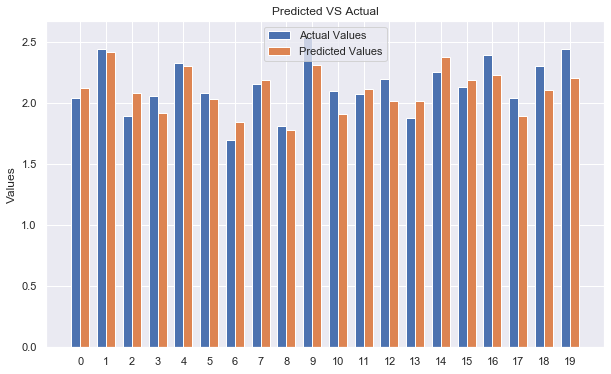

In [74]:
Act = error_diff1['Actual Values'].tolist()
Pre = error_diff1['Predicted Values'].tolist()
labels = np.arange(0,20).tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, Act, width, label='Actual Values')
rects2 = ax.bar(x + width/2, Pre, width, label='Predicted Values')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_xticklabels(labels)
ax.set_xticks(x)
ax.set_title('Predicted VS Actual')
ax.legend(loc='upper right')
plt.show()

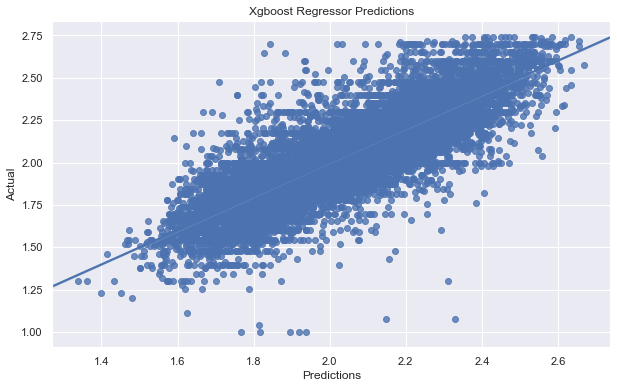

In [75]:
plt.figure(figsize=(10,6))
sns.regplot(y_pred,y_test2)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Xgboost Regressor Predictions")
plt.show()

In [72]:
y_pred_xgb1= xgb_model.predict(x_train2)
y_pred_xgb2= xgb_model.predict(x_test2)
XGB_best_results = pd.DataFrame({'algorithm':['XGBoost Regression'],
            'training_error': [mean_squared_error(y_train2, y_pred_xgb1)],
            'test_error': [mean_squared_error(y_test2, y_pred_xgb2)],
            'training_r2_score': [r2_score(y_train2, y_pred_xgb1)],
            'test_r2_score': [r2_score(y_test2, y_pred_xgb2)]})
pd.options.display.float_format = '{:.2%}'.format
XGB_best_results

,algorithm,training_error,test_error,training_r2_score,test_r2_score
0,XGBoost Regression,1.82%,2.22%,76.01%,70.70%


## Model Comparison and Conclusion##

In [73]:
#combined scores of all model's best results
df_conclusion = pd.concat([randomforest_best_results,gb_best_results,XGB_best_results], axis=0, ignore_index=True)
df_conclusion

,algorithm,training_error,test_error,training_r2_score,test_r2_score
0,Random Forest Regression,1.68%,2.28%,77.81%,69.96%
1,Gradient Boosting Regression,1.82%,2.24%,76.05%,70.48%
2,XGBoost Regression,1.82%,2.22%,76.01%,70.70%


From the result data frame, models adopting ensemble techniques triumph linear models. Furthermore, ensemble models adopting boosting method have slightly better performance. XGBoosting Regression Model has the best performance of 70.70% prediction accuracy score. And Gradient Boosting Regressor gives a close second score of 70.48%. In addition, there could be less concern of over-fitting in the Boosting Models due to the relatively lower differences between training and testing errors, even though there is no certain indication of over-fitting issue here. Overall, the three ensemble models have very similar performances. The only defect in boosting method is time-consuming due to serial-computing. 

## Limitations of Our Models

Although we get impressive results from above regression analyzes, there are still limitations of our project. First is that we use the logarithm of the price as the dependent variable in our models. This method makes the distribution of price more like a normal distribution and decrease the possible errors in the computation, but if we use the original price, the error may be enlarged. Second is that it is difficult for us to entirely understand the hyperparameter of each model, and our laptops' function also has limitation, so we can't get the best hyperparameters of models.

Another limitation of our models is that we miss some important features, which render our models able to predict around 70% of the dataset. One feature we think we miss is how the pictures of the Airbnb houses/apartments appeal to customers and how fancy they look. Future studies can take this feature into consideration. 

## Text Anlysis##

In [75]:
df_text['price'] = df1['price']
df_text.head()

,amenities,name,summary,space,description,price
0,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",22500.00%
1,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,8900.00%
2,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,20000.00%
3,"{Wifi,""Air conditioning"",Kitchen,""Pets live on...",BlissArtsSpace!,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,6000.00%
4,"{TV,Wifi,""Air conditioning"",""Paid parking off ...",Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"You will use one large, furnished, private roo...",Please don’t expect the luxury here just a bas...,7900.00%


In [76]:
print(df1.price.mean())
print(df1.price.std())

158.22181365280827
348.1332417456828


In [77]:
pattern = re.compile(r'[^\w\s]')
df_text_conditioned = df_text[df_text['price']>175]
df_text_conditioned.shape

(12501, 6)

We select the price that is larger than 500.

In [78]:
amenities_text = ''
for i in df_text_conditioned['amenities']:
    amenities_text += i

name_text = ''
for i in df_text_conditioned['name'].to_string():
    name_text += i

space_text = ''
for i in df_text_conditioned['space'].to_string():
    space_text += i

In [79]:
# tokenize amenities
cv1 = CountVectorizer(stop_words = 'english', lowercase=True)
tk_func1 = cv1.build_analyzer()
amenities_tokens = tk_func1(amenities_text)
amenities_token_freqdist = FreqDist(amenities_tokens)
amenities_token_freqdist.most_common(20)

[('detector', 20707),
 ('dryer', 16431),
 ('tv', 15257),
 ('friendly', 12929),
 ('wifi', 12425),
 ('heating', 11983),
 ('essentials', 11792),
 ('air', 11732),
 ('conditioning', 11730),
 ('kitchen', 11693),
 ('smoke', 11221),
 ('hangers', 9820),
 ('carbon', 9486),
 ('monoxide', 9486),
 ('hair', 9473),
 ('shampoo', 9290),
 ('iron', 8873),
 ('laptop', 8642),
 ('workspace', 8642),
 ('allowed', 8026)]

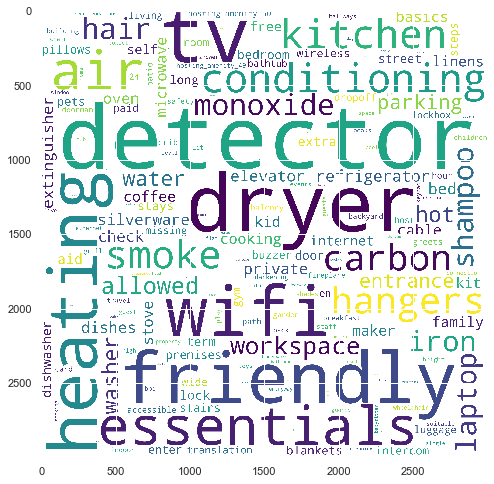

In [80]:
# wordcloud for amenities
wc1 = WordCloud(background_color='white',width=3000,height=3000).generate_from_frequencies(amenities_token_freqdist)
plt.imshow(wc1)

In [81]:
# name token
cv2 = CountVectorizer(stop_words = 'english', lowercase=True)
tk_func2 = cv2.build_analyzer()
name_token = tk_func2(name_text)
name_token_freqdist = FreqDist(name_token)
pop1 = name_token_freqdist.pop('bedroom')
pop2 = name_token_freqdist.pop('room')
pop3 = name_token_freqdist.pop('apartment')
name_token_freqdist.most_common(20)

[('apt', 1496),
 ('village', 1036),
 ('east', 1027),
 ('luxury', 976),
 ('studio', 974),
 ('spacious', 925),
 ('loft', 884),
 ('park', 856),
 ('manhattan', 782),
 ('west', 760),
 ('1br', 721),
 ('private', 692),
 ('nyc', 684),
 ('williamsburg', 671),
 ('heart', 669),
 ('brooklyn', 649),
 ('midtown', 639),
 ('central', 636),
 ('modern', 617),
 ('beautiful', 613)]

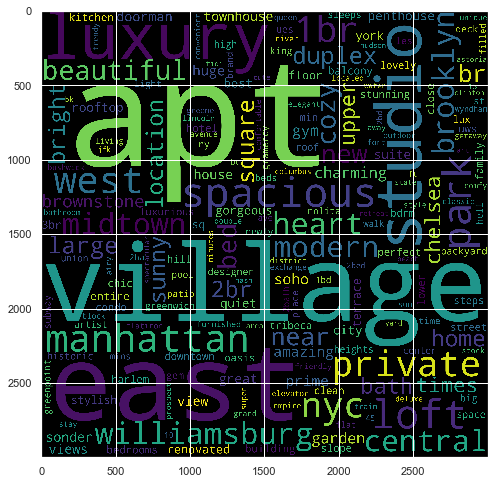

In [82]:
# name wordcloud
wc2 = WordCloud(background_color='black',width=3000,height=3000).generate_from_frequencies(name_token_freqdist)
plt.imshow(wc2)

In [83]:
# description tokens
cv3 = CountVectorizer(stop_words = 'english', lowercase=True)
tk_func3 = cv3.build_analyzer()
space_token = tk_func3(space_text)
space_token_freqdist = FreqDist(space_token)
pop1 = space_token_freqdist.pop('bedroom')
pop2 = space_token_freqdist.pop('room')
pop3 = space_token_freqdist.pop('apartment')
pop4 = space_token_freqdist.pop('nan')
space_token_freqdist.most_common(20)

[('space', 656),
 ('kitchen', 608),
 ('fully', 595),
 ('spacious', 521),
 ('floor', 519),
 ('located', 464),
 ('large', 433),
 ('equipped', 432),
 ('home', 427),
 ('new', 414),
 ('building', 413),
 ('beautiful', 367),
 ('private', 349),
 ('bed', 347),
 ('modern', 336),
 ('loft', 304),
 ('renovated', 304),
 ('living', 290),
 ('studio', 282),
 ('bedrooms', 261)]

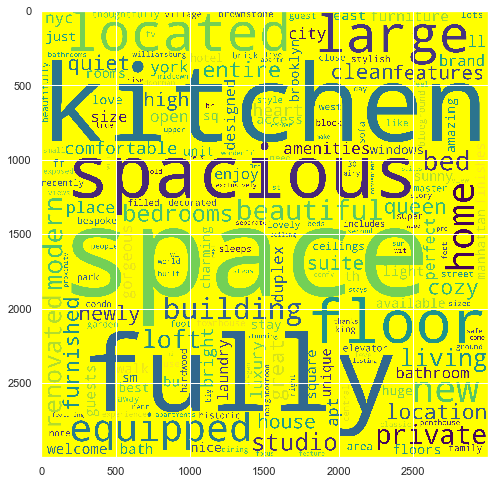

In [84]:
# description wordcloud
wc3 = WordCloud(background_color='yellow',width=3000,height=3000).generate_from_frequencies(space_token_freqdist)
plt.imshow(wc3)

## Reference ##

Robert’s notebooks​

Smart Pricing with XGB, RFR + Interpretations.https://www.kaggle.com/jrw2200/smart-pricing-with-xgb-rfr-interpretations ​

Prediction with XGB,GBR + Data exploration.https://www.kaggle.com/nishok03/price-prediction-with-xgb-gbr-data-exploration ​

Scikit-learn (GBDT). https://www.cnblogs.com/pinard/p/6143927.html ​

GBDT. https://www.jianshu.com/p/e8eb25bca7ad​